In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

In [2]:
Ravdess="archive//"
ravdess_directory_list=os.listdir("archive//")
print(ravdess_directory_list)
file_emotion=[]
file_path=[]
for dir in ravdess_directory_list:
    actor=os.listdir(Ravdess+dir)    #archive//Actor_01
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        if int(part[2])==1 or int(part[2])==7:
            continue
        else:
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({ 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 8:'surprise'}, inplace=True)
Ravdess_df.shape

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


(1152, 2)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


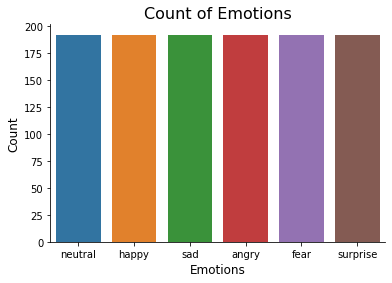

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [4]:
import librosa

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


In [5]:
def extract_features(data):
    result = np.array([])
    sample_rate=22050
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=5, offset=0.6)
    data, sample_rate = librosa.load(path, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
#     data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [7]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 2 times as we have made 1 augmentation techniques on each audio file.
        Y.append(emotion)

In [8]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [9]:
Features = pd.read_csv('features.csv')

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, shuffle=True,random_state=13)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2937, 162), (2937, 6), (519, 162), (519, 6))

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, shuffle=True,random_state=13)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((2496, 162), (2496, 6), (441, 162), (441, 6))

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2496, 162), (2496, 6), (519, 162), (519, 6), (441, 162), (441, 6))

In [23]:
import pickle
with open("SerScaler", "wb") as f: 
    pickle.dump(scaler, f)

In [15]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, x_test.shape, x_val.shape

((2496, 162, 1), (519, 162, 1), (441, 162, 1))

In [16]:
model=Sequential()

model.add(Conv1D(256, kernel_size=5, strides=2, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(256, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.1))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [17]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.8, verbose=2, patience=4, min_lr=0.0000001)
early_stopping_monitor = (EarlyStopping(patience=15))
history=model.fit(x_train, y_train, batch_size=15, epochs=100, validation_data=(x_val, y_val),
                  callbacks=[rlrp,early_stopping_monitor], verbose=1)

Epoch 1/100
167/167 [==============================] - 31s 19ms/step - loss: 1.7333 - accuracy: 0.2284 - val_loss: 1.5222 - val_accuracy: 0.3220
Epoch 2/100
167/167 [==============================] - 2s 11ms/step - loss: 1.5489 - accuracy: 0.3373 - val_loss: 1.4134 - val_accuracy: 0.4195
Epoch 3/100
167/167 [==============================] - 2s 12ms/step - loss: 1.3934 - accuracy: 0.4263 - val_loss: 1.3846 - val_accuracy: 0.4195
Epoch 4/100
167/167 [==============================] - 2s 12ms/step - loss: 1.2927 - accuracy: 0.4569 - val_loss: 1.2150 - val_accuracy: 0.5102
Epoch 5/100
167/167 [==============================] - 2s 12ms/step - loss: 1.1504 - accuracy: 0.5313 - val_loss: 1.2158 - val_accuracy: 0.4943
Epoch 6/100
167/167 [==============================] - 2s 12ms/step - loss: 1.0924 - accuracy: 0.5599 - val_loss: 1.0870 - val_accuracy: 0.5646
Epoch 7/100
167/167 [==============================] - 2s 12ms/step - loss: 0.9527 - accuracy: 0.6157 - val_loss: 1.0624 - val_accuracy

In [18]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

17/17 [==============================] - 0s 11ms/step - loss: 1.6418 - accuracy: 0.8131
Accuracy of our model on test data :  81.3102126121521 %


0.8132870842497453


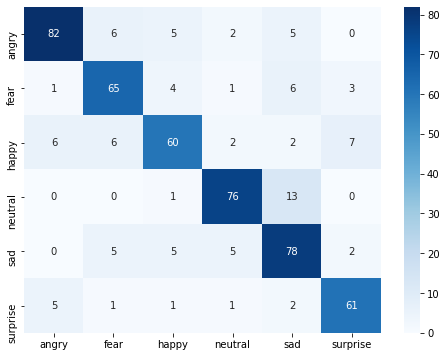

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
y_pred=model.predict(x_test)
ytest=encoder.inverse_transform(y_test)
ypred=encoder.inverse_transform(y_pred)
conmat=confusion_matrix(ytest,ypred)
con_mat=pd.DataFrame(conmat,columns=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'],index=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

print(f1_score(ytest, ypred, average='macro'))
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(con_mat, cmap="Blues",annot=True,)
plt.show()

In [22]:
model.save("fser.h5")